In [11]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy.stats import skew, kurtosis


In [12]:
#Static parameters from machining settings used as features to distinguish between sets

#Parameters in sets.csv
static_params_csv = "../data/rawsets/sets.csv"
static_df = pd.read_csv(static_params_csv)

#Extract numeric set ID from the first column
static_df.rename(columns={static_df.columns[0]: "set_str"}, inplace=True)
static_df["set"] = static_df["set_str"].str.extract(r"Set (\d+)").astype(int)
static_df.set_index("set", inplace=True)

#Replace "?" with NaN
static_df.replace("?", np.nan, inplace=True)

#Convert numeric columns to float
numeric_cols = ["Vc", "n", "fz", "Vf", "Ae", "Ap"]
for col in numeric_cols:
    static_df[col] = pd.to_numeric(static_df[col], errors='coerce')

#Fill NaNs with median
static_df[numeric_cols] = static_df[numeric_cols].fillna(static_df[numeric_cols].median())

#Only use cutting parameters that might be useful for sensor data, so exclude crop, Coating, z, material for now
#Might be worth it to include information of material, but for now we use only until set 13, which means one set with different material
print(static_df[numeric_cols])




        Vc       n     fz     Vf  Ae   Ap
set                                      
1    162.0  3444.5  0.048  170.0   1  1.0
2    120.0  2547.0  0.080  203.0   1  1.0
3    150.0  3184.0  0.050  159.0   1  1.0
4    174.0  3705.0  0.050  185.0   1  1.0
5    174.0  3705.0  0.040  148.0   1  1.0
6    174.0  3705.0  0.040  170.0   1  1.0
7    174.0  3705.0  0.045  170.0   1  1.0
8    174.0  3705.0  0.048  178.0   1  1.0
9    174.0  3705.0  0.048  178.0   1  0.5
10   174.0  3705.0  0.050  185.0   1  0.5
11   174.0  3705.0  0.043  159.0   1  1.0
12   120.0  2547.0  0.050  127.0   1  0.5
13   150.0  3184.0  0.050  159.0   1  0.5
14   135.0  2866.0  0.060  172.0   1  0.5
15   120.0  2547.0  0.030   76.0   1  1.0
16   150.0  3184.0  0.030   95.0   1  1.0
17   150.0  3184.0  0.030  191.0   1  1.0


In [13]:
#For now 1 to 13
all_sets = range(1, 14)

#Initialize X and Y and "sets"
X_all, Y_all, sets_all = [], [], []

for set_id in all_sets:
    print(f"Loading set {set_id}")

    #Paths
    sensor_folder = f"../data/processed/set{set_id}/sensordata"
    wear_csv = f"../data/processed/set{set_id}/merged.csv"

    if not os.path.exists(wear_csv):
        print(f"Skipping set {set_id} (no CSV)")
        continue

    #Load csv
    wear_df = pd.read_csv(wear_csv)

    #Keep only flank wear samples, suggest by Tom (Sirris)
    #Include flank_wear+adhesion?
    wear_df = wear_df[wear_df["type"].isin(["flank_wear","flank_wear+adhesion"])]#

    current_set = None

    #Active time since start of current set
    cumulative_time = 0.0  
    
    #Same parameters per set
    static_params = static_df.loc[set_id, numeric_cols].values.astype(float)

    for _, row in wear_df.iterrows():
        #Check which set
        set_number = row["set"]
        if current_set != set_number:
            #New set, so reset cumulative time
            current_set = set_number
            cumulative_time = 0.0
            print(f"Starting new set: {set_number}")
            
        #Find sensor file corresponds to wear level row
        sensor_file = os.path.join(sensor_folder, os.path.basename(row["sensor_window_path"]))
        if not os.path.exists(sensor_file):
            continue

        #Load sensor file
        data = np.load(sensor_file)
        
        #Get sensor data
        sensors = np.stack([data[k] for k in ["accel", "acoustic", "force_x", "force_y", "force_z"]], axis=1)

        #Each file corresponds to sensor data measured between two pictures taken, and for that picture we have one wear level value
        #So, to meaningfully describe this sensor data, the mean, standard deviation and rms are extracted which correspond to one wear level (wanted output)
        mean = sensors.mean(axis=0)
        std = sensors.std(axis=0)
        rms = np.sqrt((sensors ** 2).mean(axis=0))
        
        sk = skew(sensors, axis=0)
        ku = kurtosis(sensors, axis=0, fisher=False)
        crest = np.max(np.abs(sensors), axis=0) / (rms + 1e-8)

        fx = sensors[:, 2]
        fy = sensors[:, 3]
        fz = sensors[:, 4]
        force_resultant_rms = np.sqrt((fx**2 + fy**2 + fz**2).mean())

        #Combine features
        features = np.concatenate([mean, std, rms, sk, ku, crest, [force_resultant_rms]])

        #Get duration in one sensor file corresponding to 1 output
        timestamps = pd.to_datetime(data["timestamp"])
        duration = (timestamps[-1] - timestamps[0]).total_seconds()

        #Keep track of cumulative time tool is used
        t_value = cumulative_time
        cumulative_time += duration 

        #Add to X and Y and "sets"
        X_all.append(np.concatenate([[t_value], features, static_params]))
        Y_all.append([row["wear"]]) 
        sets_all.append(set_id) 

X_all = np.array(X_all)
Y_all = np.array(Y_all)
sets_all = np.array(sets_all)

print("X_all shape:", X_all.shape)
print("Y_all shape:", Y_all.shape)
print("Sets:", np.unique(sets_all))



Loading set 1
Starting new set: 1
Loading set 2
Starting new set: 2
Loading set 3
Starting new set: 3


/var/folders/7x/0pnrdfvn0ts5vvq0s97bwpl80000gn/T/ipykernel_81690/127947010.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(sensors, axis=0)
/var/folders/7x/0pnrdfvn0ts5vvq0s97bwpl80000gn/T/ipykernel_81690/127947010.py:60: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ku = kurtosis(sensors, axis=0, fisher=False)


Loading set 4
Starting new set: 4
Loading set 5
Starting new set: 5
Loading set 6
Starting new set: 6
Loading set 7
Starting new set: 7
Loading set 8
Starting new set: 8
Loading set 9
Starting new set: 9
Loading set 10
Starting new set: 10
Loading set 11
Starting new set: 11
Loading set 12
Starting new set: 12
Loading set 13
Starting new set: 13
X_all shape: (1027, 38)
Y_all shape: (1027, 1)
Sets: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [14]:
# sensor_names = ["accel", "acoustic", "force_x", "force_y", "force_z"]
# stat_names = ["mean", "std", "rms", "skew", "kurtosis", "crest"]

# feature_names = []

# # time feature
# feature_names.append("cumulative_time")

# # sensor statistics
# for stat in stat_names:
#     for s in sensor_names:
#         feature_names.append(f"{stat}_{s}")

# # force resultant rms
# feature_names.append("force_resultant_rms")

# # static parameters
# static_feature_names = numeric_cols


# all_feature_names = feature_names + static_feature_names


# X_df = pd.DataFrame(X_all, columns=all_feature_names)
# Y_df = pd.DataFrame(Y_all, columns=["wear"])

# X_df.head()


WARNING: Set 6 has non-monotonic wear: 45.0 -> 30.0

WARNING: Set 10 has non-monotonic wear: 60.0 -> 45.0

In [15]:
#Splits
train_sets = {2, 5, 7, 8, 10, 11} #Excluded 1 for now
val_sets   = {3, 6, 12}
test_sets  = {4, 9, 13}

train_mask = np.isin(sets_all, list(train_sets))
val_mask   = np.isin(sets_all, list(val_sets))
test_mask  = np.isin(sets_all, list(test_sets))

X_train, Y_train = X_all[train_mask], Y_all[train_mask]
X_val,   Y_val   = X_all[val_mask],   Y_all[val_mask]
X_test,  Y_test  = X_all[test_mask],  Y_all[test_mask]

#Remove samples with NaN in Y, there is 1 in train and 5 in test (of which 4 rows in set 4)
mask_train = ~np.isnan(Y_train).ravel()
mask_val   = ~np.isnan(Y_val).ravel()
mask_test  = ~np.isnan(Y_test).ravel()

X_train, Y_train = X_train[mask_train], Y_train[mask_train]
X_val,   Y_val   = X_val[mask_val],   Y_val[mask_val]
X_test,  Y_test  = X_test[mask_test], Y_test[mask_test]


In [16]:
#Standardization
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)

X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)


Apply physics loss on unscaled wear:

y_pred = scaler_Y.inverse_transform(y_pred_scaled)
physics_loss(y_pred, t)


In [17]:
#Training

num_sensors = X_train_scaled.shape[1]

#Feed-forward network, only 2 hidden layers due to size of dataset
net = dde.nn.FNN([num_sensors, 64, 32, 1], "tanh", "Glorot uniform") 

#DeepXDE needs float32, not float64
data = dde.data.DataSet(
    X_train_scaled.astype(np.float32),
    Y_train_scaled.astype(np.float32),
    X_val_scaled.astype(np.float32),
    Y_val_scaled.astype(np.float32),
)

model = dde.Model(data, net)

model.compile("adam", lr=1e-4, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000, batch_size=8, display_every=500, callbacks=[dde.callbacks.EarlyStopping(patience=500)])


Compiling model...
'compile' took 0.000245 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.62e+00]    [1.69e+00]    [1.41e+00]    
500       [1.60e-01]    [6.32e-01]    [8.65e-01]    
1000      [8.60e-02]    [6.24e-01]    [8.59e-01]    
1500      [4.53e-02]    [6.44e-01]    [8.72e-01]    
2000      [2.26e-02]    [7.35e-01]    [9.32e-01]    
2500      [1.15e-02]    [8.70e-01]    [1.01e+00]    
3000      [6.24e-03]    [9.17e-01]    [1.04e+00]    
3500      [3.46e-03]    [8.98e-01]    [1.03e+00]    
4000      [1.89e-03]    [8.81e-01]    [1.02e+00]    
4500      [9.83e-04]    [8.83e-01]    [1.02e+00]    
5000      [4.71e-04]    [8.90e-01]    [1.03e+00]    
5500      [2.04e-04]    [8.89e-01]    [1.03e+00]    
6000      [7.88e-05]    [8.81e-01]    [1.02e+00]    
6500      [2.76e-05]    [8.69e-01]    [1.01e+00]    
7000      [8.96e-06]    [8.58e-01]    [1.01e+00]    
7500      [2.70e-06]    [8.48e-01]    [1.00e+00]    
8000      [7.11e-07]    [8.40e-01]

In [18]:
#Prediction
print("Train sets:", np.unique(sets_all[train_mask]))
print("Val sets:", np.unique(sets_all[val_mask]))
print("Test sets:", np.unique(sets_all[test_mask]))

Y_val_pred_scaled = model.predict(X_val_scaled.astype(np.float32))
Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_scaled)
print("Predictions shape:", Y_val_pred.shape)

Y_test_pred_scaled = model.predict(X_test_scaled.astype(np.float32))
Y_test_pred = scaler_Y.inverse_transform(Y_test_pred_scaled)
print("Predictions shape:", Y_test_pred.shape)

#Evaluation
# val_mse = mean_squared_error(Y_val, Y_val_pred)
# test_mse = mean_squared_error(Y_test, Y_test_pred)

# print("MSE - Validation:", val_mse)
# print("MSE - Test:", test_mse)

val_mae = mean_absolute_error(Y_val, Y_val_pred)
test_mae = mean_absolute_error(Y_test, Y_test_pred)

print("MAE - Validation:", val_mae)
print("MAE - Test:", test_mae)

Train sets: [ 2  5  7  8 10 11]
Val sets: [ 3  6 12]
Test sets: [ 4  9 13]
Predictions shape: (294, 1)
Predictions shape: (232, 1)
MAE - Validation: 70.19838802161671
MAE - Test: 102.31055430297194


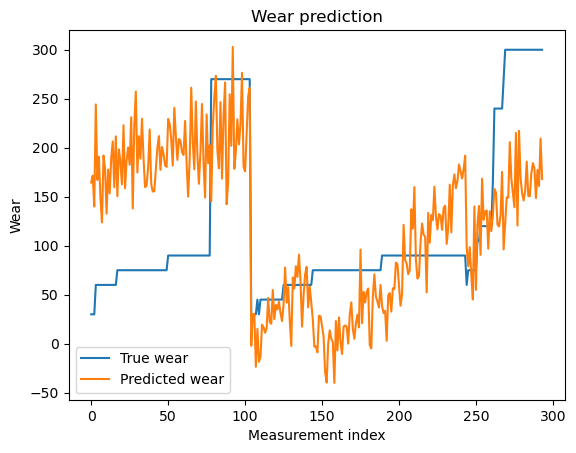

In [19]:
plt.figure()
plt.plot(Y_val, label="True wear")
plt.plot(Y_val_pred, label="Predicted wear")
plt.legend()
plt.xlabel("Measurement index")
plt.ylabel("Wear")
plt.title("Wear prediction")
plt.show()


In [20]:
# plt.figure()
# plt.scatter(X_val[:, 0], Y_val, label="True wear")
# plt.scatter(X_val[:, 0], Y_val_pred, label="Predicted wear", s=10)
# plt.xlabel("Cumulative time")
# plt.ylabel("Wear")
# plt.legend()
# plt.show()
